In [1]:
import sys
sys.path.append("../")

# Legacy Import Fix
from DiffusionModules.Legacy.DiffusionModules import *
import DiffusionModules.Legacy.DiffusionModules as DiffusionModules
from DiffusionModules.Legacy.Diffusion import *
import DiffusionModules.Legacy.Diffusion as Diffusion
from DiffusionModules.Legacy.DiffusionTrainer import *
import DiffusionModules.Legacy.DiffusionTrainer as DiffusionTrainer
from DiffusionModules.Legacy.ClipTranslatorModules import *
import DiffusionModules.Legacy.ClipTranslatorModules as ClipTranslatorModules

sys.modules['Diffusion'] = Diffusion
sys.modules['DiffusionModules'] = DiffusionModules
sys.modules['DiffusionTrainer'] = DiffusionTrainer
sys.modules['ClipTranslatorModules'] = ClipTranslatorModules
sys.modules['DiffusionModules.ClipTranslatorModules'] = ClipTranslatorModules


import os
import torch
import torchvision
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchinfo import summary
plt.rcParams['figure.figsize'] = [10, 5]

2023-06-22 12:47:31.827532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 12:47:32.461542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-22 12:47:32.461652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-22 12:47:32.461661: W tensorfl

In [2]:
import glob
checkpoint = glob.glob("/home/jovyan/DiffusionModels/DiffusionModels/samples_coco_upscale/*.ckpt")[0]

pretrained_dict = torch.load(checkpoint, map_location="cuda:1")
state_dict = pretrained_dict["state_dict"]
pretrained_dict = {f"{k.split('.', 1)[1]}": v for k, v in state_dict.items() if "ema_unet" in k}
model = UpscalerUNet(device="cuda:1")
model.load_state_dict(pretrained_dict)

model = UpscalerDiffusionTrainer.load_from_checkpoint(checkpoint, unet=model, map_location="cuda:1", device="cuda:1", dev="cuda:1")
model = model.eval()
model.diffusion_tools._device = "cuda:1"
model.alt_validation_emb_provider.clip_tools._clip_model.to("cuda:1")
0

0

In [3]:
clip_tools = ClipTools(device="cuda:1")
emb = ClipTranslatorEmbeddingProvider("/home/jovyan/DiffusionModels/DiffusionModels/clip_translator/model.ckpt", clip_tools=clip_tools, device="cuda:1")

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [13]:
cifar_path = "/home/archive/cifar10-64"
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.ImageFolder(f"{cifar_path}/train")

def collate_none(data):
    data = list(filter(lambda x: x[0] is not None and x[1] is not None, data))
    images = [e[0] for e in data]
    captions = [e[1] for e in data]
    return images, captions

train_load = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=1, collate_fn=collate_none)

for batch in train_load:
    images, labels = batch
    image = images[10]
    label= labels[10]
    break
    
caption = None
image_py = model.diffusion_image_transformer.transform_image(image).unsqueeze(0).to("cuda:1")
i_embs = emb.get_embedding(None, [classes[label]]).to("cuda:1")

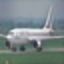

In [14]:
image


Sampling Images: : 100%|██████████| 1000/1000 [02:38<00:00,  6.30it/s]


tensor(-0.6919, device='cuda:1') tensor(0.8740, device='cuda:1') tensor(0.0203, device='cuda:1')


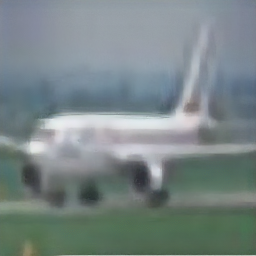

In [15]:
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

model.diffusion_image_transformer.reverse_transform_image(model.diffusion_tools.sample_images(model.unet, 1, i_embs, 9, x_appendex=image_py).cpu()[0])